## SVM

Default LinearSVC achieve worse results than logistic regression. SVC, on the other hand, works good for negative class (0.91) and much worse for positive (0.47), based on averaged cross validation.

Replacing CountVectorizer with TfIdfVectorizer improved averaged CV (0.86 / 0.55). From EDA (TruncatedSGD) it can be seen that it helps to distinguish the targets. Accuracy went up.

Lemmatization didn't help.

Bi-grams didn't help with Kaggle results, but slightly improved those from cross validation and final training.

Dropping all duplicates didn't help. Dropping only those with different targets improved metrics but not Kaggle score.

In [165]:
%load_ext autoreload
%autoreload 2

import re
import itertools
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [166]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [167]:
print(len(train_df))

targets_df = train_df.groupby('text').nunique().sort_values(by='target', ascending=False)
mismatched_texts = list(targets_df[targets_df['target'] > 1].index)
train_df = train_df[train_df['text'].isin(mismatched_texts) == False]
train_df.reset_index(drop=False)

print(len(train_df))
train_df[:3]

7613
7558


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [168]:
train_df['text'].isnull().values.any()

False

## Preprocessing

In [169]:
EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

nlp = spacy.load('en_core_web_sm')

# disable not used parts of pipeline
def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

# train_df['text_preproc'] = train_df['text_preproc'].apply(_lemma)
train_df[:3]

,id,keyword,location,text,target,text_preproc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...


## Data split

In [170]:
X = train_df['text_preproc']
y = train_df['target']

X[:3]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
Name: text_preproc, dtype: object

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

750        bfowler i see that crazy how this line blew up
5392                         panic attacks are the worst 
5757    retweeted sarah silverman sarahksilverman\n\ns...
Name: text_preproc, dtype: object

### Parameter center

In [172]:
VECT_MIN=2
VECT_MAX=0.4

## Vectorization

In [173]:
with open('../resources/stopwords_en.txt', encoding='utf-8') as f:
    stopwords = [line.rstrip() for line in f]

stopwords[:3]

['i', 'me', 'my']

In [174]:
vec = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)

print(vec.get_feature_names()[:10])

['aa', 'aba', 'abandon', 'abandoned', 'abbott', 'abbswinston', 'abc', 'abcnews', 'abe', 'ability']


In [175]:
svc = SVC()
svc.fit(X_train_vec, y_train)

SVC()

In [176]:
print(svc.score(X_train_vec, y_train))
print(svc.score(X_test_vec, y_test))

0.9591465431690374
0.8240740740740741


[[803  64]
 [202 443]]
Normalized confusion matrix


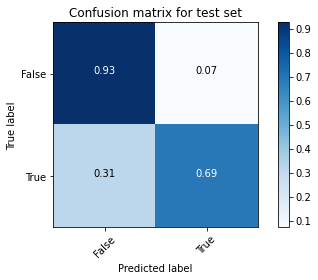

In [177]:
y_pred_test = svc.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_test)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm, [False, True])

In [178]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       867
           1       0.87      0.69      0.77       645

    accuracy                           0.82      1512
   macro avg       0.84      0.81      0.81      1512
weighted avg       0.83      0.82      0.82      1512



## Grid search

In [179]:
# from sklearn.model_selection import GridSearchCV
#
# params = [
#     {
#         'C':[0.1, 1, 10],
#         'kernel' : ['rbf', 'linear', 'sigmoid'],
#         'tol': [0.01, 0.001, 0.0001]
#     },
#     {
#         'C':[0.1, 1, 10],
#         'kernel' : ['poly'],
#         'degree': [2, 3, 4],
#         'tol': [0.01, 0.001, 0.0001]
#     }
#  ]
#
# svc = SVC()
# clf = GridSearchCV(svc, params)
# clf.fit(X_train_vec, y_train)
# print(sorted(clf.cv_results_.keys()))
# print()
# print(clf.cv_results_)
# print()
# print(clf.best_estimator_)
# print()
# print(clf.best_score_)
# print()
# print(clf.best_params_)

## Cross validation

TRAIN: 5668 TEST: 1890
CV ACCURACY: 0.9574805928016937


TRAIN: 5668 TEST: 1890
CV ACCURACY: 0.9597741707833451


TRAIN: 5669 TEST: 1889
CV ACCURACY: 0.9580172869994708


TRAIN: 5669 TEST: 1889
CV ACCURACY: 0.9555477156464985


[[3775  538]
 [1472 1773]]
Normalized confusion matrix


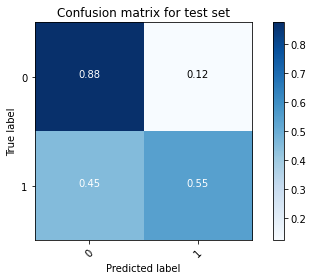

In [180]:
X_cv = train_df['text_preproc']
y_cv = train_df['target']

CONF_MATRIXES = []

skf = StratifiedKFold(n_splits=4)
for train_idx, test_idx in skf.split(X_cv, y_cv):
    print('TRAIN:', len(train_idx), 'TEST:', len(test_idx))
    X_train_cv, X_test_cv = X_cv.iloc[train_idx], X_cv.iloc[test_idx]
    y_train_cv, y_test_cv = y_cv.iloc[train_idx], y_cv.iloc[test_idx]

    vec_cv = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
    X_train_vec_cv = vec_cv.fit_transform(X_train_cv)
    X_test_vec_cv = vec_cv.transform(X_test_cv)

    svc_cv = SVC(tol=0.01)
    svc_cv.fit(X_train_vec_cv, y_train_cv)
    accuracy_cv = svc_cv.score(X_train_vec_cv, y_train_cv)

    print(f'CV ACCURACY: {accuracy_cv}')
    y_pred_cv = svc_cv.predict(X_test_vec_cv)
    cm = confusion_matrix(y_test_cv, y_pred_cv)
    CONF_MATRIXES.append(cm)
    print('\n')

# overall results
cm = np.array(CONF_MATRIXES).sum(axis=0)
plot_confusion_matrix(cm, [0, 1])

## Final model training

0.9542206933051072
[[4259   54]
 [ 292 2953]]
Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4313
           1       0.98      0.91      0.94      3245

    accuracy                           0.95      7558
   macro avg       0.96      0.95      0.95      7558
weighted avg       0.96      0.95      0.95      7558



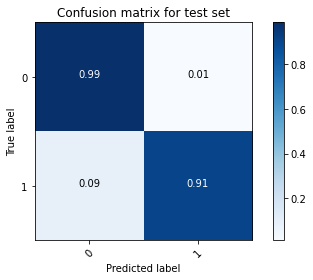

In [181]:
vec = TfidfVectorizer(min_df=VECT_MIN, max_df=VECT_MAX)
X_vec = vec.fit_transform(X)

svc = SVC(tol=0.01)
svc.fit(X_vec, y)
print(svc.score(X_vec, y))

y_pred = svc.predict(X_vec)

cm = confusion_matrix(y, svc.predict(X_vec))
plot_confusion_matrix(cm, [0, 1])

print(classification_report(y, y_pred))

In [182]:
test_df[:3]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [183]:
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)
X_out = test_df['text_preproc']
X_out

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4             typhoon soudelor kills  in china and taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm in ri worse than last hurricane my citya...
3260    green line derailment in chicago httptcoutbxlc...
3261    meg issues hazardous weather outlook hwo httpt...
3262    cityofcalgary has activated its municipal emer...
Name: text_preproc, Length: 3263, dtype: object

In [184]:
X_out_vec = vec.transform(X_out)
X_out_vec

<3263x6380 sparse matrix of type '<class 'numpy.float64'>'
	with 34952 stored elements in Compressed Sparse Row format>

In [185]:
y_out_pred = svc.predict(X_out_vec)
y_out_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [186]:
file = pd.DataFrame({
   'id': test_df['id'],
   'target': y_out_pred
})

file.to_csv('disaster-tweets-svm-tfidf-drop-dupl.csv', index=False)